# Testing interpolation at different points

## Setup

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    15:02:43 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    15:02:43 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    15:02:43 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43893")
client

<Client: 'tcp://127.0.0.1:43893' processes=4 threads=16, memory=125.81 GiB>

In [4]:
# define function
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da

We want to see how interpolation at different stages affects the final result. Let's use the lake drainage in 2022 at A11 for this

In [5]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=1,time=range(4400,4900)),2,3e8,4e8)


In [6]:
da_101_stacked.time

<xarray.DataArray 'time' (time: 500)>
array(['2022-07-11T13:07:20.000000000', '2022-07-11T13:21:47.000000000',
       '2022-07-11T13:36:49.000000000', ..., '2022-07-16T17:21:57.000000000',
       '2022-07-16T17:36:51.000000000', '2022-07-16T17:51:51.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-07-11T13:07:20 ... 2022-07-16T17:51:51

In [7]:
time_to_interp = pd.date_range("2022-07-11 13:15", freq="15min", periods=5 * 4*24)
interp_chirp = ds_101.chirp.isel(attenuator_setting_pair=1,time=range(4400,4900)).compute()
interp_chirp = interp_chirp.interp(time=time_to_interp,method='linear')

Interpolating chirp requires bringing all the chirp data to disk. Might not be good for lots of data

In [8]:
profiles_interp_chirp = custom_stacked_profile_series(interp_chirp,2,3e8,4e8)

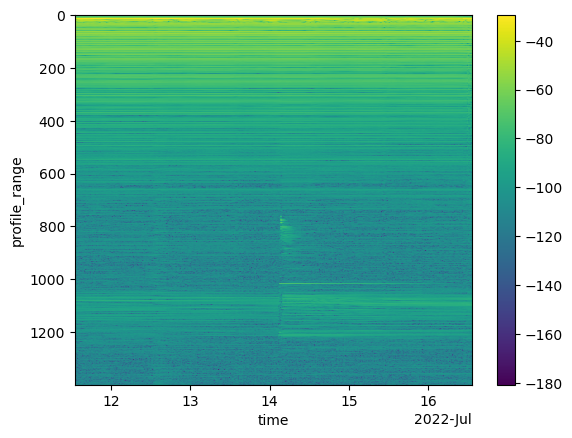

In [9]:
xa.dB(profiles_interp_chirp).plot(x='time')
plt.gca().invert_yaxis()

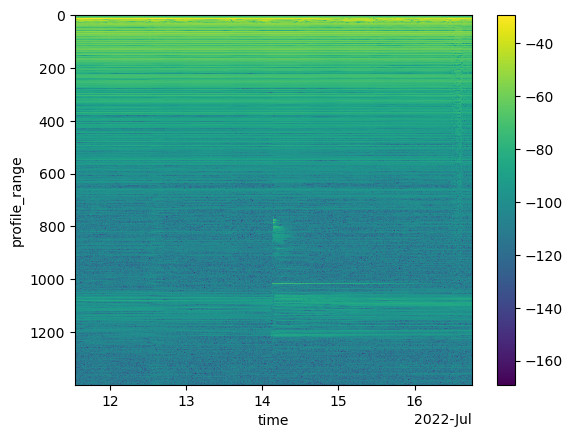

In [10]:
xa.dB(da_101_stacked).plot(x='time')
plt.gca().invert_yaxis()

In [52]:
# Interpolate complex value
profiles_interp_profiles = da_101_stacked.interp(time=time_to_interp,method='linear')

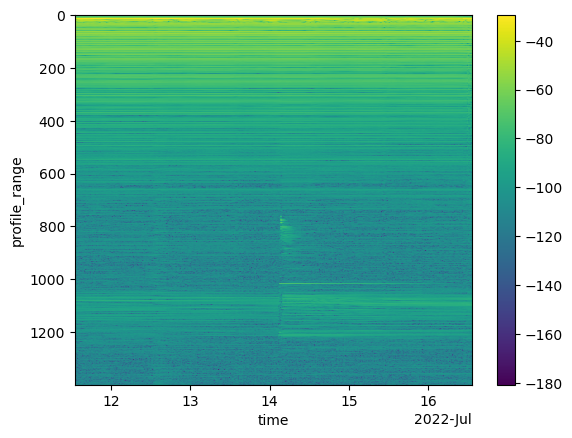

In [56]:
xa.dB(profiles_interp_profiles).plot(x='time')
plt.gca().invert_yaxis()

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/computation.py:822: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


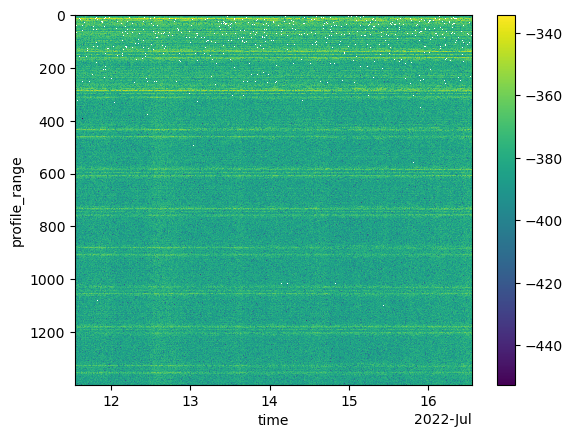

In [53]:
xa.dB(abs(profiles_interp_profiles-profiles_interp_chirp)).plot(x='time')
plt.gca().invert_yaxis()

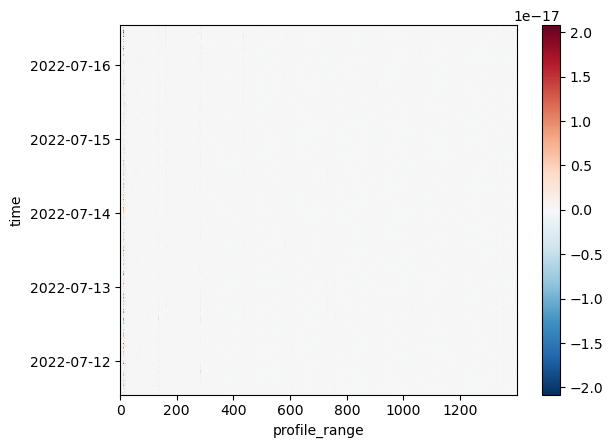

In [54]:
(abs(profiles_interp_profiles)-abs(profiles_interp_chirp)).plot()

I think comparing between the stages at when to interpolate, interpolating after the profile calculation is fine (especially given computational space)

In [55]:
def generate_strain_fit_drainage(ds,window,lag,lims=None):
    # New method
    b1= ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=600).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv-vv.mean())**2).sum(dim='profile_range')
    
    # Old Method
    b1= ds.isel(time=range(0,len(ds)-1))
    b2 = ds.isel(time=range(1,len(ds)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_old = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')
    vv_old = ds_old.range_diff.coarsen(time=lag,boundary='trim').sum()/ds_old.time_diff.coarsen(time=lag,boundary='trim').sum()*31536000
    vv_old_err = np.sqrt(((ds_old.err)**2).coarsen(time=lag,boundary='trim').sum())/ds_old.time_diff.coarsen(time=lag,boundary='trim').sum()*31536000
    fit_old=vv_old.where(vv_old.profile_range <=600).polyfit('profile_range',1,full=True)
    r2_old = 1-fit_old.polyfit_residuals/((vv_old-vv_old.mean())**2).sum(dim='profile_range')
    
    # Plotting
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='leapfrog')
    axs[0].plot(fit_old.time.values,fit_old.polyfit_coefficients.sel(degree=1).values,label='summation')
    #axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[0].legend(loc="upper left", ncol=2)
    axs[1].plot(fit.time.values,r2.values,linestyle='None',marker='.')
    axs[1].plot(fit_old.time.values,r2_old.values)
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    
    fig1, axs_1 = plt.subplots(ncols=6,figsize=(19,5),sharey=True,layout='constrained')
    #fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
    vv_times = np.arange(math.ceil(0.3*len(vv_old.time)),math.ceil(0.9*len(vv_old.time)),math.ceil(0.6*len(vv_old.time))//6)
    for i in range(6):
        time = vv_old.time.isel(time = vv_times[i]).values
        axs_1[i].errorbar(vv.sel(time = time,method="nearest") ,vv.profile_range,yerr=None,xerr=vv_err.sel(time = time,method="nearest"),marker='.',zorder=1)
        axs_1[i].errorbar(vv_old.sel(time = time,method="nearest") ,vv_old.profile_range,yerr=None,xerr=vv_old_err.sel(time = time,method="nearest"),linestyle='',marker='.',zorder=2)
        #slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

        #axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
        unit = ''#'x10$^{-3}$ yr$^{-1}$'
        #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
        axs_1[i].set_title(f'{time.astype(str)[:16]}'.replace('T',' '))
        if lims:
            axs_1[i].set_xlim(lims)
        axs_1[i].set_ylim([20,1400])
        axs_1[i].tick_params(axis='both', which='major', labelsize=14)


    axs_1[0].invert_yaxis()

    axs_1[0].set_ylabel('depth [m]',fontsize=18)
    fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)
    return vv,vv_err,vv_old,vv_old_err

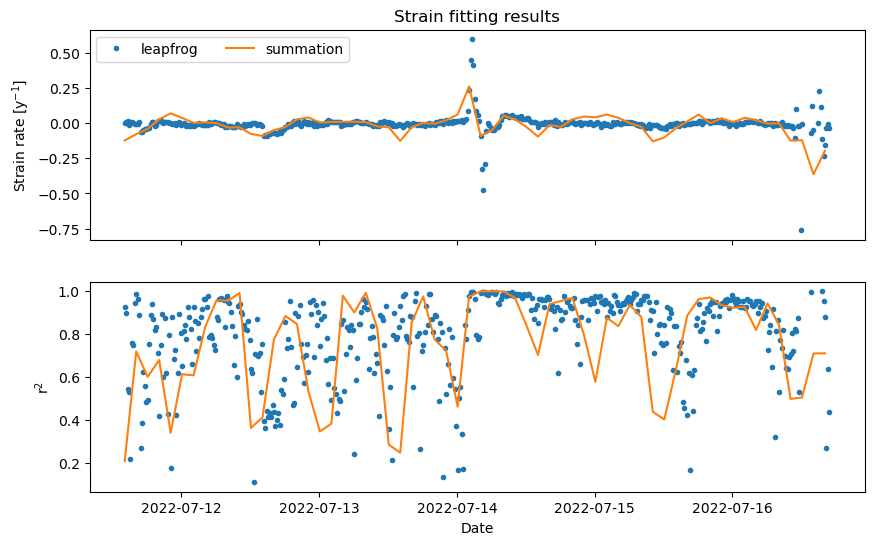

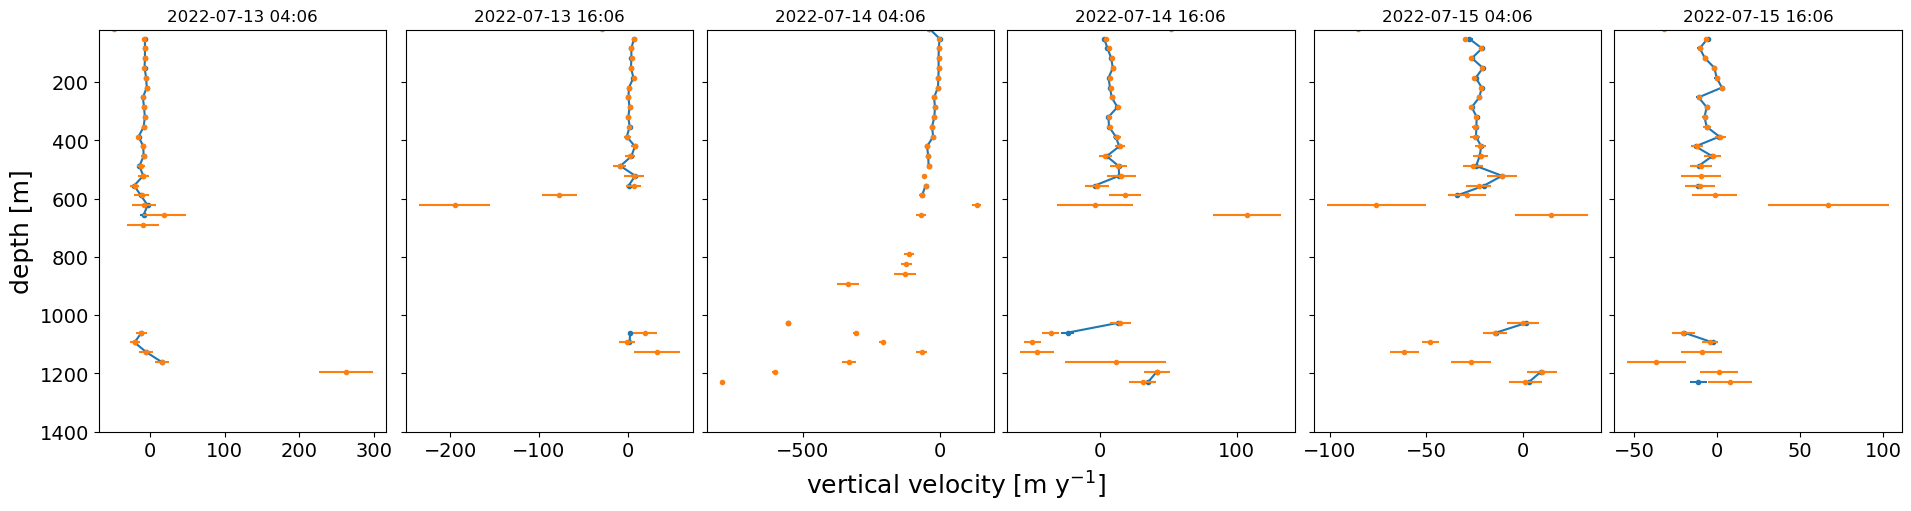

In [57]:
vv,vv_err,vv_old,vv_old_err = generate_strain_fit_drainage(da_101_stacked,80,8)


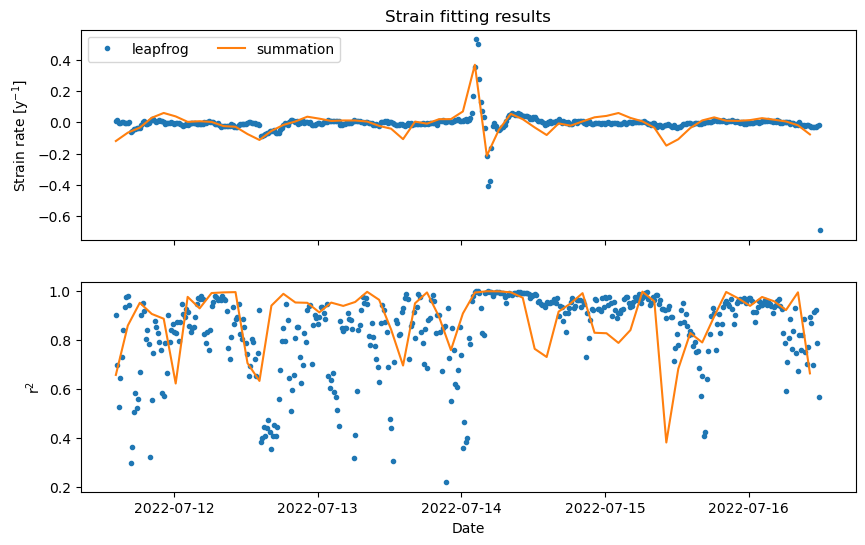

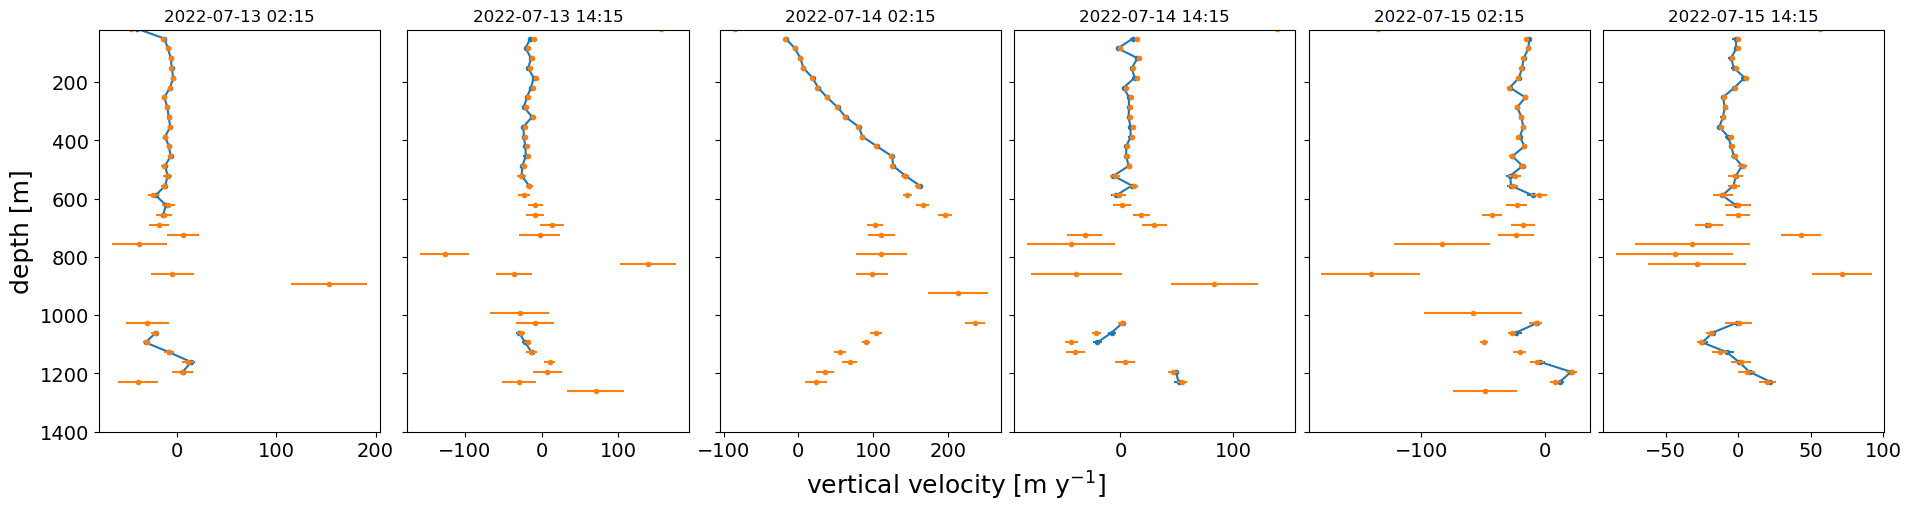

In [58]:
vv,vv_err,vv_old,vv_old_err = generate_strain_fit_drainage(profiles_interp_profiles,80,8)


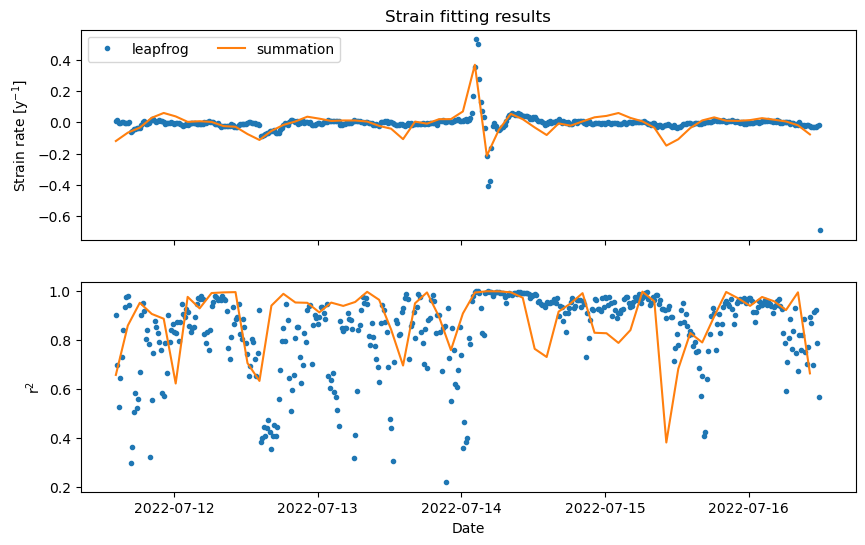

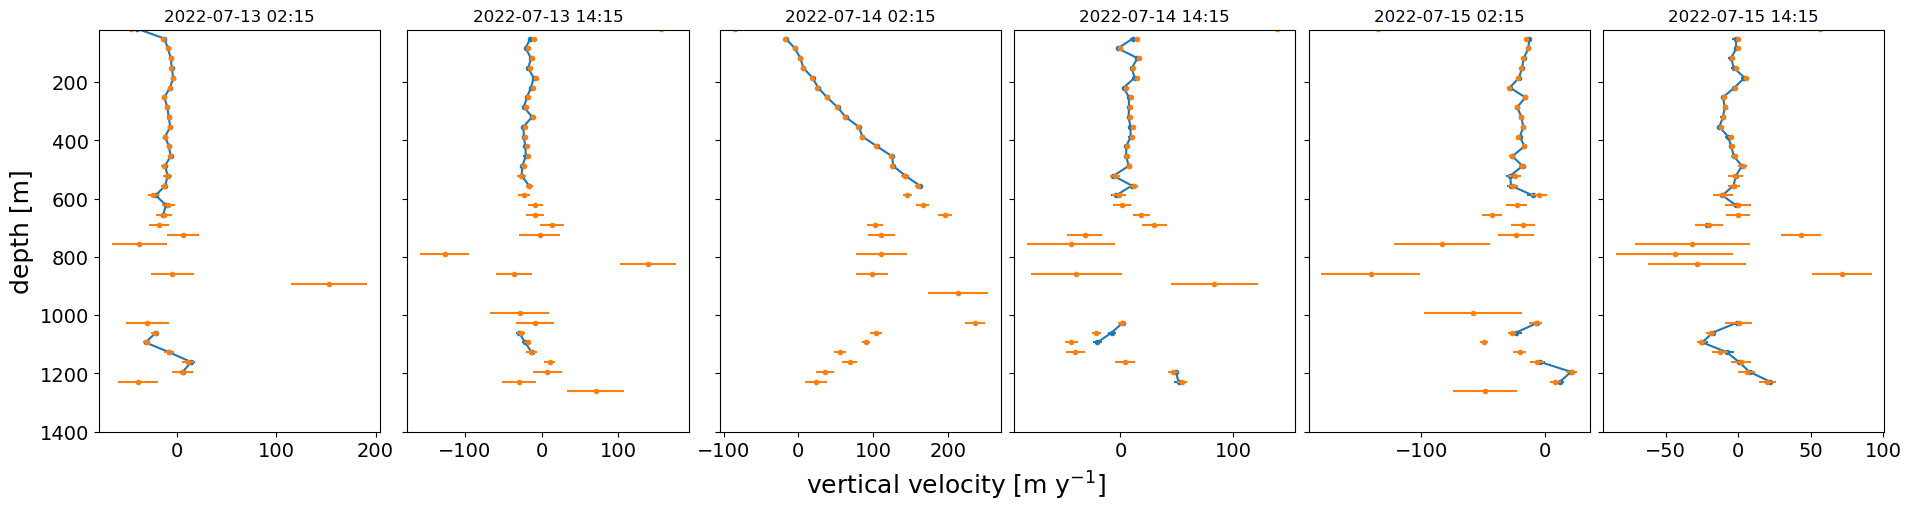

In [59]:
vv,vv_err,vv_old,vv_old_err = generate_strain_fit_drainage(profiles_interp_chirp,80,8)
